In [2]:
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util

%matplotlib inline
import matplotlib.pyplot as plt

from boostedhiggs.structure import buildevents

In [3]:
fin = uproot.open('data/TTToHadronic_TuneCP5_13TeV-powheg-pythia8_10X.root')
tree = fin['Events']
df = processor.LazyDataFrame(tree, stride=20000, index=0, flatten=True)
events = buildevents(df)

In [29]:
leadingmuon = events.muons.pad(1, clip=True).flatten()
leadingjet = events.fatjets.pad(1, clip=True).flatten()
met = events.met

In [68]:
from uproot_methods import TLorentzVectorArray

In [78]:
joffshell = leadingjet.msoftdrop < 125/2  # halfway point between offshell and onshell W
massassumption = 80.*joffshell + (125 - 80.)*~joffshell
x = massassumption**2/(2*leadingmuon.p4.pt*met.rho) + np.cos(leadingmuon.p4.phi - met.phi)
met_eta = (
    (x < 1)*np.arcsinh(x*np.sinh(leadingmuon.p4.eta))
    + (x > 1)*(
        leadingmuon.p4.eta
        - np.sign(leadingmuon.p4.eta)*np.arccosh(leadingmuon.p4.eta)
    )
)
met_p4 = TLorentzVectorArray.from_ptetaphim(met.rho, met_eta.fillna(0.), met.phi, np.zeros(met.size))

/Users/ncsmith/src/awkward-array/awkward/array/masked.py:242: RuntimeWarning: invalid value encountered in arccosh
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [93]:
leadingmuon

<MaskedArray [None <muon 0> None ... None None <muon 12126>] at 0x0001cd98d6d0>

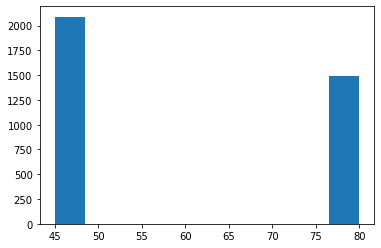

In [37]:
plt.hist(massassumption.fillna(np.nan));

In [3]:
bosons = events.genpart[
    (np.abs(events.genpart.pdgId) >= 21)
    & (np.abs(events.genpart.pdgId) <= 37)
    & (events.genpart.statusFlags & ((1<<7)|(1<<13))).astype(bool)  # isHardProcess, isLastCopy
    & (events.genpart.genPartIdxMother >= 0)
]
candidatejet = events.fatjets[:,:1]
ak8_boson_pair = candidatejet.cross(bosons, nested=True)
ak8_boson_pair['dR2'] = ak8_boson_pair.i0.p4.delta_r2(ak8_boson_pair.i1.p4)
ak8_boson_pair['dPt2'] = ((ak8_boson_pair.i0.p4.pt - ak8_boson_pair.i1.p4.pt)/(ak8_boson_pair.i0.p4.pt + ak8_boson_pair.i1.p4.pt))**2

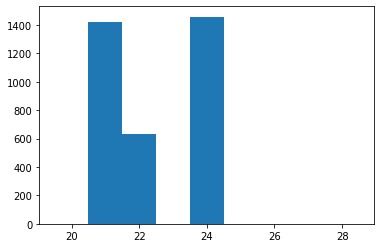

In [4]:
matchedBoson = ak8_boson_pair.i1[(ak8_boson_pair.dR2 + ak8_boson_pair.dPt2).argmin()].flatten(axis=1)
plt.hist(matchedBoson.pdgId.flatten(), bins=np.arange(20, 30)-.5);

In [5]:
ak8_boson_pair

<JaggedArray [[] [] [] ... [] [] [[<tuple 82790> <tuple 82791> <tuple 82792> ... <tuple 82801> <tuple 82802> <tuple 82803>]]] at 0x0001c5467190>

In [6]:
fatjets = events.fatjets

fatjets['msdcorr'] = boostedhiggs.corrected_msoftdrop(fatjets)
fatjets['rho'] = 2*np.log(fatjets.msdcorr / fatjets.p4.pt)
fatjets['n2ddt'] = fatjets.n2 - boostedhiggs.n2ddt_shift(fatjets, year='2018')

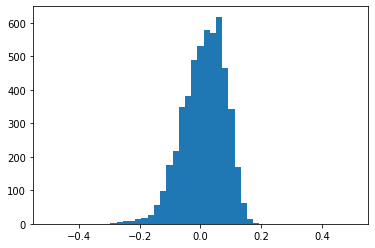

In [7]:
plt.hist(fatjets.n2ddt.flatten(), bins=np.linspace(-0.5, 0.5, 50));

In [8]:
leadingjet = fatjets[:, 0:1]

good = ((leadingjet.p4.pt > 450)
        & (leadingjet.p4.eta < 2.4)
        & (leadingjet.jetId & 2).astype(bool)  # tight
        & (leadingjet.n2ddt < 0.)
        & (leadingjet.msdcorr > 40)
       )

good_event = good.all()

In [9]:
jets = events.jets
ak4_ak8_pair = jets.cross(leadingjet, nested=True)
dphi = ak4_ak8_pair.i0.p4.delta_phi(ak4_ak8_pair.i1.p4)
opp = (np.abs(dphi) > np.pi / 2).all()
# only consider first 4 jets to be consistent with old framework
ak4_opposite = jets[opp & (jets.p4.pt > 30.) & (jets.localindex < 4)]

btagLooseWPs = {
    '2016': 0.6321,
    '2017': 0.4941,
    '2018': 0.4184,
}
good_event &= ak4_opposite.deepcsvb.max() < btagLooseWPs['2018']

In [10]:
nelectrons = ((events.electrons.cutBased & (1<<2)).astype(bool) & (events.electrons.p4.pt > 20)).counts
nmuons = (events.muons.looseId & (events.muons.p4.pt > 20)).counts
ntaus = (events.taus.idDecayMode & (events.taus.p4.pt > 20)).counts
good_event &= (events.met.rho < 140.) & (nmuons == 0) & (nelectrons == 0) & (ntaus == 0)

In [11]:
print("Passed %d of %d events" % (good_event.sum(), good_event.size))

Passed 449 of 20000 events
